In [1]:
# Authenticate user for Google Cloud (Vertex AI) access
from google.colab import userdata
from google.colab import auth
auth.authenticate_user()
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')
GOOGLE_CLOUD_PROJECT=userdata.get('GOOGLE_CLOUD_PROJECT')


# Importing libraries :
# !pip3 install langchain_google_genai --quiet --exists-action i --no-input
# !pip3 install langchain --quiet --exists-action i --no-input
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
import operator
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langgraph.checkpoint.memory import MemorySaver

In [2]:
# creating a model
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    project=GOOGLE_CLOUD_PROJECT,
    location="global",
    temperature=1.3,
)

In [3]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]
    #why BaseMessage : all types of messages like Human, AI, System are inheriated from BaseMessage so into the list any kind of message is present

    # as in previous tutorial we used `operator.add` to store previous values but while working with langgraph its recommended to use `add_messages` from "langgraph.graph.message"

In [4]:
def chat_node(state: ChatState) -> ChatState:
    # take user query from state
    messages = state['messages']

    # pass it to LLM
    response = model.invoke(messages)

    # store the received response in state
    return{'messages':[response]}

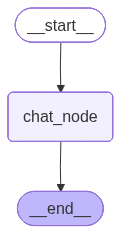

In [5]:
# check pointer
checkpointer = MemorySaver()

# graph
graph = StateGraph(ChatState)

# node
graph.add_node('chat_node',chat_node)

# edges
graph.add_edge(START,'chat_node')
graph.add_edge('chat_node',END)

# compile
chatbot = graph.compile(checkpointer=checkpointer)
chatbot

In [6]:
initial_state ={
    'messages':[HumanMessage(content="What is the capital of India?")]
}

thread_id = 'simple_1'
config = {
        'configurable':{
            'thread_id':thread_id
        }
    }

# chatbot.invoke(initial_state)
chatbot.invoke(initial_state,config=config)['messages'][-1].content

'The capital of India is **New Delhi**.'

In [7]:
# let build it looks like a chatbot
# while True:
#     user_message = input('Type here:')
#     print('User: ', user_message)
#     if user_message.strip().lower() in ['exit','bye','quit']:
#         break
#     response = chatbot.invoke(
#         {
#             'messages':[HumanMessage(content=user_message)]
#         }
#     )

#     print('AI:', response['messages'][-1].content)
#     print(f"{'----====----' * 2}")


# but here a big problem is related to memory
# it can store a data even for short time too

# Example Output:
# Type here:hello, I am pranav
# User:  hello, I am pranav
# AI: Hello Pranav! It's nice to meet you. How can I help you today?
# ----====--------====----
# Type here:what's my name?
# User:  what's my name?
# AI: I do not have access to personal information, including your name. Therefore, I cannot tell you what your name is.
# ----====--------====----
# Type here:bye
# User:  bye

In [8]:
# as we have included MemoeySaver() and checkpointer
# we have define a thread whcih is nothing but interaction between chatbot
thread_id = '1'
# along with that we need to define a config too

# let build it looks like a chatbot
while True:
    user_message = input('Type here:')
    print('User: ', user_message)
    if user_message.strip().lower() in ['exit','bye','quit']:
        break

    config = {
        'configurable':{
            'thread_id':thread_id
        }
    }
    response = chatbot.invoke(
        {
            'messages':[HumanMessage(content=user_message), ]
        },
        config=config
    )

    print('AI:', response['messages'][-1].content)
    print(f"{'----====----' * 2}")

# Example Output
# Type here:hello, my name is Pranav Nachankar
# User:  hello, my name is Pranav Nachankar
# AI: Hello Pranav Nachankar! It's nice to meet you.

# How can I assist you today?
# ----====--------====----
# Type here:what is my name?
# User:  what is my name?
# AI: Your name is **Pranav Nachankar**. You just told me! 😊
# ----====--------====----
# Type here:bye
# User:  bye

Type here:Hello
User:  Hello
AI: Hello there! How can I help you today?
----====--------====----
Type here:My name is Pranav
User:  My name is Pranav
AI: Hello Pranav! It's nice to meet you. What can I do for you?
----====--------====----
Type here:add 10 in 100
User:  add 10 in 100
AI: 100 + 10 = 110
----====--------====----
Type here:what is my name?
User:  what is my name?
AI: Your name is Pranav.
----====--------====----
Type here:what is the last total sum?
User:  what is the last total sum?
AI: The last total sum was **110**.
----====--------====----
Type here:bye
User:  bye


In [9]:
chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='79a3e995-e081-4cfa-b1a0-ecf3c7184a48'), AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcbda-6a44-7580-b446-021f754da77b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='My name is Pranav', additional_kwargs={}, response_metadata={}, id='b51ffe08-7d31-4d69-9b1d-8a3e8fc36fc5'), AIMessage(content="Hello Pranav! It's nice to meet you. What can I do for you?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bcbda-959e-7f32-a019-963e2